24/03/19 17:46:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.



Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.04      0.00      0.00       486
           1       0.49      0.94      0.64       486

    accuracy                           0.47       972
   macro avg       0.26      0.47      0.32       972
weighted avg       0.26      0.47      0.32       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.59      0.74       486
           1       0.71      1.00      0.83       486

    accuracy                           0.79       972
   macro avg       0.85      0.79      0.79       972
weighted avg       0.85      0.79      0.79       972



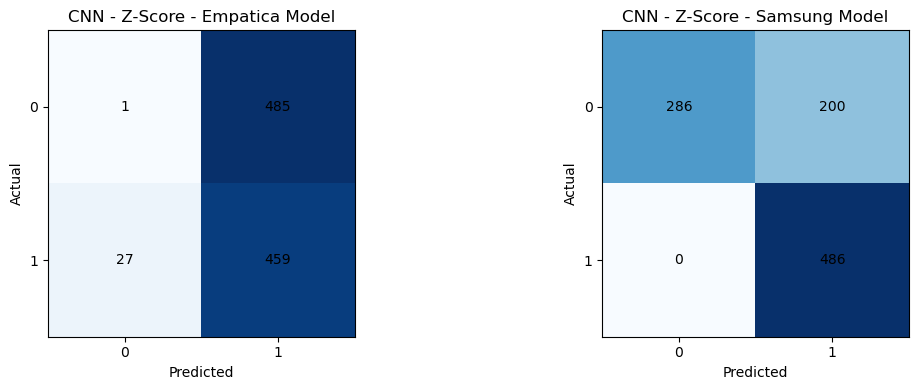

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("RandomForestWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/z-score/a_training.csv"
testing_file_path = "./data/6-data-split/z-score/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Train Random Forest models
rf_empatica = RandomForestClassifier(
    labelCol="CL", featuresCol="features_empatica", seed=5, maxDepth=10
)
rf_samsung = RandomForestClassifier(
    labelCol="CL", featuresCol="features_samsung", seed=5, maxDepth=10
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, rf_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, rf_samsung])

# Train models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions
predictions_empatica = model_empatica.transform(testing_df)
predictions_samsung = model_samsung.transform(testing_df)

# Extracting predicted and true labels for Empatica Model (CNN)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Extracting predicted and true labels for Samsung Model (CNN)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")
y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)


# Calculate confusion matrices
conf_mat_empatica_cnn = np.zeros((2, 2))
conf_mat_samsung_cnn = np.zeros((2, 2))

for i in range(len(y_true_empatica_cnn)):
    conf_mat_empatica_cnn[y_true_empatica_cnn[i], y_pred_empatica_cnn[i]] += 1

for i in range(len(y_true_samsung_cnn)):
    conf_mat_samsung_cnn[y_true_samsung_cnn[i], y_pred_samsung_cnn[i]] += 1

# Print classification reports
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Create a single figure for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot confusion matrices
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("CNN - Z-Score - Empatica Model")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("CNN - Z-Score - Samsung Model")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the figure
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()

24/03/19 17:46:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.



Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.03      0.00      0.00       486
           1       0.49      0.94      0.64       486

    accuracy                           0.47       972
   macro avg       0.26      0.47      0.32       972
weighted avg       0.26      0.47      0.32       972


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       1.00      0.59      0.74       486
           1       0.71      1.00      0.83       486

    accuracy                           0.79       972
   macro avg       0.85      0.79      0.79       972
weighted avg       0.85      0.79      0.79       972



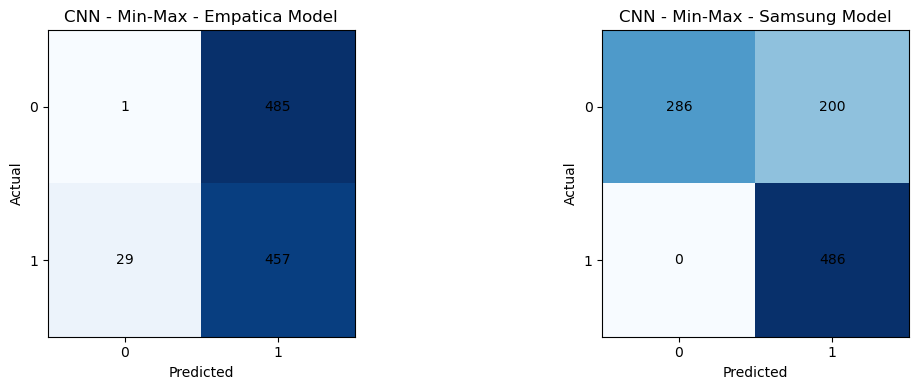

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("RandomForestWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/min-max/a_training.csv"
testing_file_path = "./data/6-data-split/min-max/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Train Random Forest models
rf_empatica = RandomForestClassifier(
    labelCol="CL", featuresCol="features_empatica", seed=5, maxDepth=10
)
rf_samsung = RandomForestClassifier(
    labelCol="CL", featuresCol="features_samsung", seed=5, maxDepth=10
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, rf_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, rf_samsung])

# Train models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions
predictions_empatica = model_empatica.transform(testing_df)
predictions_samsung = model_samsung.transform(testing_df)

# Guidance for extracting predicted and true labels for Empatica model (CNN), provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Guidance for extracting predicted and true labels for Samsung model (CNN), provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")
y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)


# Guidance for computing the confusion matrices, provided by ChatGPT
# Specific implementation details were adapted for the purposes of this project.
conf_mat_empatica_cnn = np.zeros((2, 2))
conf_mat_samsung_cnn = np.zeros((2, 2))

for i in range(len(y_true_empatica_cnn)):
    conf_mat_empatica_cnn[y_true_empatica_cnn[i], y_pred_empatica_cnn[i]] += 1

for i in range(len(y_true_samsung_cnn)):
    conf_mat_samsung_cnn[y_true_samsung_cnn[i], y_pred_samsung_cnn[i]] += 1

# Print classification reports
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Create a single figure for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot confusion matrices
axes[0].imshow(conf_mat_empatica_cnn, cmap="Blues")
axes[0].set_title("CNN - Min-Max - Empatica Model")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        axes[0].text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

axes[1].imshow(conf_mat_samsung_cnn, cmap="Blues")
axes[1].set_title("CNN - Min-Max - Samsung Model")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        axes[1].text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

# Show the figure
plt.tight_layout()
plt.show()

# Stop SparkSession
spark.stop()